In [1]:
!pip install librosa

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from IPython.display import Audio

# Set a consistent style for plots
sns.set_style('whitegrid')

In [2]:
# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your main audio directory
# This is the folder that contains subfolders like 'hungry', 'discomfort', etc.
AUDIO_DIR = '/content/drive/MyDrive/BabyCryProject/donateacry_corpus/'

# Verify that the path exists
if not os.path.exists(AUDIO_DIR):
    print(f"ERROR: Audio directory not found at {AUDIO_DIR}")
else:
    print("Audio directory found.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Audio directory found.


In [3]:
import glob

filepaths = []
labels = []

print("Scanning directories and creating dataset...")

# Automatically find all subdirectories in the audio directory
# Each folder is treated as a category
all_folders = [f.name for f in os.scandir(AUDIO_DIR) if f.is_dir()]

# Go through each folder found
for folder_name in all_folders:
    # The label is simply the name of the folder
    target_label = folder_name

    # Create the full path to the subfolder
    folder_path = os.path.join(AUDIO_DIR, folder_name)

    # Use glob to find all .wav files in the folder
    search_pattern = os.path.join(folder_path, '**', '*.wav')
    audio_files = glob.glob(search_pattern, recursive=True)

    # Add the file path and its label to our lists
    for file_path in audio_files:
        filepaths.append(file_path)
        labels.append(target_label)

    print(f"Found {len(audio_files)} files in '{folder_name}' folder, labeled as '{target_label}'.")


# Create a pandas DataFrame for easier handling
df = pd.DataFrame({'filepath': filepaths, 'reason': labels})

print(f"\nTotal audio files found: {len(df)}")
print("\nDataset label distribution:")
print(df['reason'].value_counts())


# --- Label Encoding ---
# Now we convert the text labels into numbers for the model
unique_reasons = sorted(df['reason'].unique()) # Sort for consistency
reason_mapping = {label: i for i, label in enumerate(unique_reasons)}
df['label'] = df['reason'].map(reason_mapping)

# Create an inverse mapping to convert numbers back to text for testing later
inverse_reason_mapping = {i: label for label, i in reason_mapping.items()}

print("\nData after processing:")
display(df.head())
print("\nLabel mapping created:")
print(reason_mapping)

Scanning directories and creating dataset...
Found 382 files in 'hungry' folder, labeled as 'hungry'.
Found 27 files in 'discomfort' folder, labeled as 'discomfort'.
Found 24 files in 'tired' folder, labeled as 'tired'.
Found 8 files in 'burping' folder, labeled as 'burping'.
Found 16 files in 'belly_pain' folder, labeled as 'belly_pain'.

Total audio files found: 457

Dataset label distribution:
reason
hungry        382
discomfort     27
tired          24
belly_pain     16
burping         8
Name: count, dtype: int64

Data after processing:


,filepath,reason,label
0,/content/drive/MyDrive/BabyCryProject/donateac...,hungry,3
1,/content/drive/MyDrive/BabyCryProject/donateac...,hungry,3
2,/content/drive/MyDrive/BabyCryProject/donateac...,hungry,3
3,/content/drive/MyDrive/BabyCryProject/donateac...,hungry,3
4,/content/drive/MyDrive/BabyCryProject/donateac...,hungry,3



Label mapping created:
{'belly_pain': 0, 'burping': 1, 'discomfort': 2, 'hungry': 3, 'tired': 4}


In [4]:
!pip install resampy

In [5]:
# Define a function to extract MFCC features from an audio file
def extract_features(file_path, max_pad_len=174):
    """
    Extracts MFCCs from an audio file and pads/truncates them to a fixed length.
    """
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast', duration=5)

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)

        # Pad or truncate the MFCCs to ensure uniform length
        if mfccs.shape[1] > max_pad_len:
            mfccs = mfccs[:, :max_pad_len]
        else:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
    return mfccs

# --- Process all audio files ---
features = []

print("Starting feature extraction...")
# Loop through each file path in our DataFrame
for file_path in df['filepath']:
    # Extract features
    mfccs = extract_features(file_path)

    # Add the features to our list
    if mfccs is not None:
        features.append(mfccs)

print(f"Feature extraction complete. Extracted features for {len(features)} files.")

# Convert the list of features and labels to numpy arrays
X = np.array(features)
y = df['label'].values

Starting feature extraction...
Feature extraction complete. Extracted features for 457 files.


In [6]:
# Get the full list of file paths to split along with the data
all_filepaths = df['filepath'].values

# Split the data into training (80%) and a temporary set (20%)
# We include 'all_filepaths' in the split
X_train, X_temp, y_train, y_temp, paths_train, paths_temp = train_test_split(
    X, y, all_filepaths, test_size=0.2, random_state=42, stratify=y
)

# Split the temporary set into validation (10%) and test (10%)
X_val, X_test, y_val, y_test, paths_val, paths_test = train_test_split(
    X_temp, y_temp, paths_temp, test_size=0.5, random_state=42, stratify=y_temp
)


# Reshape the data for the CNN model (add a channel dimension)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Training set shape: {X_train.shape} | Samples: {len(paths_train)}")
print(f"Validation set shape: {X_val.shape} | Samples: {len(paths_val)}")
print(f"Test set shape: {X_test.shape}     | Samples: {len(paths_test)}")
print(f"Number of classes: {len(np.unique(y))}")

Training set shape: (365, 40, 174, 1) | Samples: 365
Validation set shape: (46, 40, 174, 1) | Samples: 46
Test set shape: (46, 40, 174, 1)     | Samples: 46
Number of classes: 5


In [7]:
# Get the input shape from the training data and the number of classes
input_shape = X_train.shape[1:]
num_classes = len(unique_reasons)

# Build the Sequential model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Second Convolutional Block
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Third Convolutional Block
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Flatten the feature maps to feed into the dense layers
    Flatten(),

    # Dense Layer for classification
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output Layer with a neuron for each cry category
    Dense(num_classes, activation='softmax')
])

# Compile the model with an optimizer, loss function, and metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 172, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 40, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 20, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 20, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       983,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,076,485 (4.11 MB)

 Trainable params: 1,076,485 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss curves.
    """
    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

Starting model training...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 539ms/step - accuracy: 0.5698 - loss: 14.5091 - val_accuracy: 0.8261 - val_loss: 0.8036
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8145 - loss: 0.8738 - val_accuracy: 0.8261 - val_loss: 0.8185
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8499 - loss: 0.7115 - val_accuracy: 0.8261 - val_loss: 0.9644
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8294 - loss: 0.7654 - val_accuracy: 0.8261 - val_loss: 0.8787
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8176 - loss: 0.8004 - val_accuracy: 0.8261 - val_loss: 0.6884
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8288 - loss: 0.7550 - val_accuracy: 0.8261 - val_loss: 0.7967
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8602 - loss: 0.6343 - val_accuracy: 0.8261 - val_loss: 0.7993
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8260 - loss: 0.7

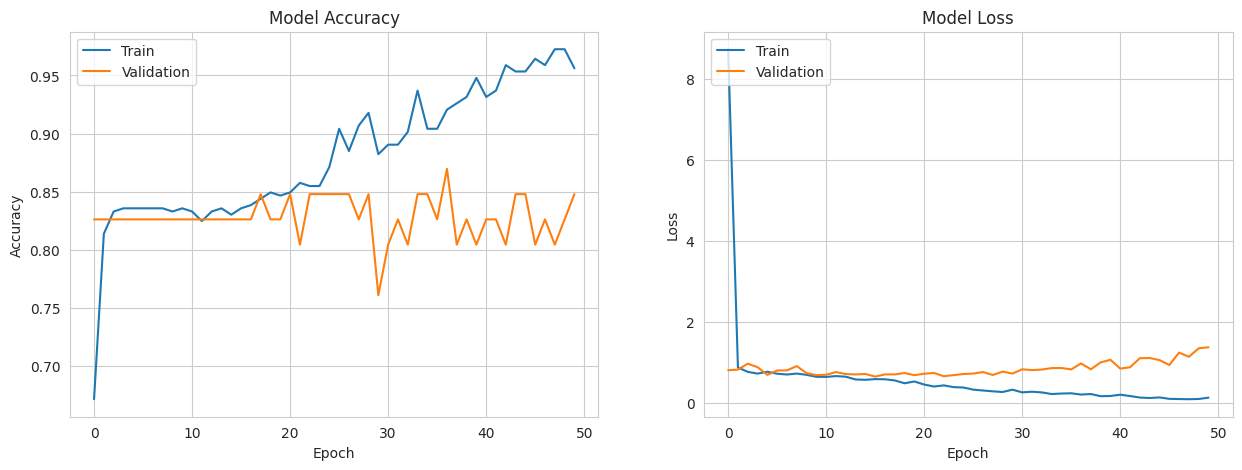

In [9]:
# Define training parameters
EPOCHS = 50
BATCH_SIZE = 32

print("Starting model training...")

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    verbose=1 # This will show a progress bar for each epoch
)

print("\nTraining finished!")

# Plot the training and validation graphs using the function we defined earlier
plot_training_history(history)

In [10]:
# Evaluate the model on the unseen test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 82.61%
Test Loss: 2.1112


---------------------------------------------------------
Testing a random sample: FF2CD2F6-404D-4626-8718-6E6C751F63B8-1431104396-1.0-m-04-hu.wav
Playing audio...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

--- Prediction Results ---
Actual Reason:    HUNGRY
Predicted Reason: HUNGRY
---------------------------------------------------------


/tmp/ipython-input-4224568861.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(reason_mapping.keys()), y=prediction_probabilities[0], palette="viridis")


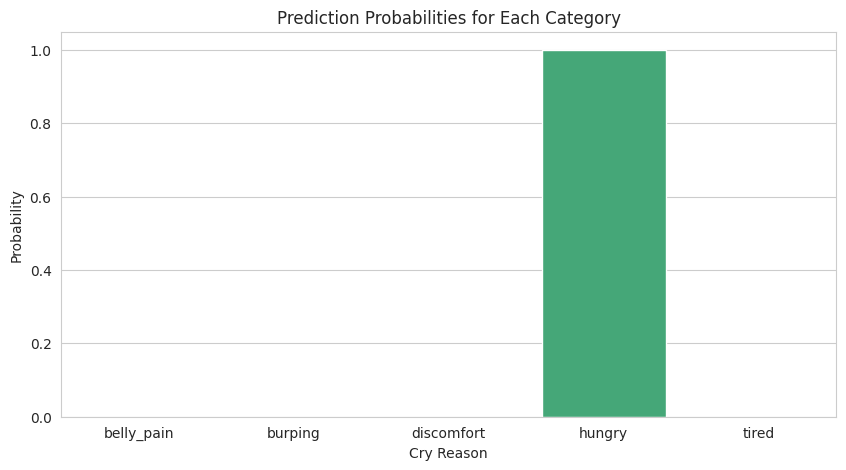

In [12]:
# Select a random index from the test set
random_index = np.random.randint(0, len(X_test))

# Get the sample's features, true label, and original file path
sample_features = X_test[random_index]
actual_label_index = y_test[random_index]
audio_path = paths_test[random_index]
actual_label_name = inverse_reason_mapping[actual_label_index]


print("---------------------------------------------------------")
print(f"Testing a random sample: {os.path.basename(audio_path)}")
print("Playing audio...")

# Play the audio file directly in the notebook
display(Audio(audio_path))

# Reshape the sample for prediction (the model expects a batch of items)
sample_for_prediction = sample_features[np.newaxis, ...]

# Make a prediction
prediction_probabilities = model.predict(sample_for_prediction)
predicted_label_index = np.argmax(prediction_probabilities)
predicted_label_name = inverse_reason_mapping[predicted_label_index]

# Print the final results
print("\n--- Prediction Results ---")
print(f"Actual Reason:    {actual_label_name.upper()}")
print(f"Predicted Reason: {predicted_label_name.upper()}")
print("---------------------------------------------------------")

# Optional: Visualize the prediction probabilities
plt.figure(figsize=(10, 5))
sns.barplot(x=list(reason_mapping.keys()), y=prediction_probabilities[0], palette="viridis")
plt.title('Prediction Probabilities for Each Category')
plt.ylabel('Probability')
plt.xlabel('Cry Reason')
plt.show()

In [13]:
# Define the file path for the saved model
model_save_path = '/content/drive/MyDrive/BabyCryProject/baby_cry_classifier.keras'

# Save the model
model.save(model_save_path)

print(f"Model successfully saved to: {model_save_path}")

Model successfully saved to: /content/drive/MyDrive/BabyCryProject/baby_cry_classifier.keras
